In [1]:
trace_directory = '/tmp/session-composed/ust'

In [2]:
import sys
# Assuming a workspace with:
#   src/tracetools_analysis/
#   src/ros2/ros2_tracing/tracetools_read/
sys.path.insert(0, '../')
sys.path.insert(0, '../../../ros2/ros2_tracing/tracetools_read/')
import os
import pickle
import matplotlib.pyplot as plt

from tracetools_analysis.analysis import load
from tracetools_analysis.analysis import ros2_processor
from tracetools_analysis.analysis import utils
from tracetools_analysis.conversion import ctf

In [3]:
# Convert
pickle_filename = 'pickle'
pickle_path = os.path.join(trace_directory, pickle_filename)
count = ctf.convert(trace_directory, pickle_path)
print(f'{count} events')

# Process
events = load.load_pickle(pickle_path)
processor = ros2_processor.ros2_process(events)
data_model = processor.get_data_model()
#data_model.print_model()

156 events


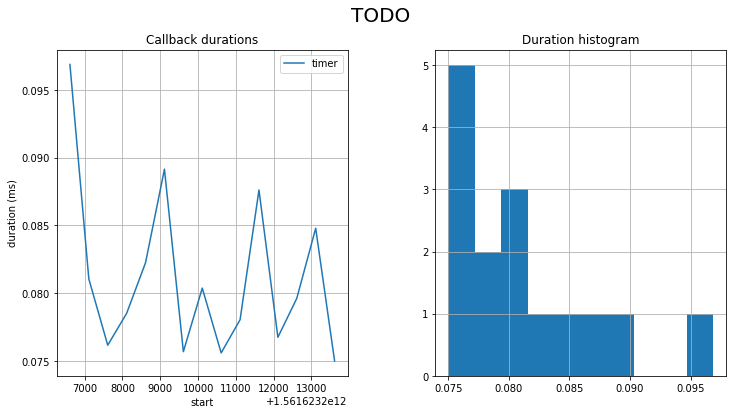

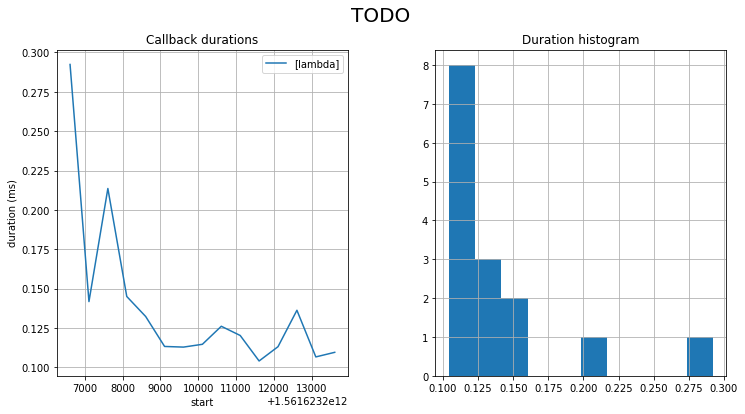

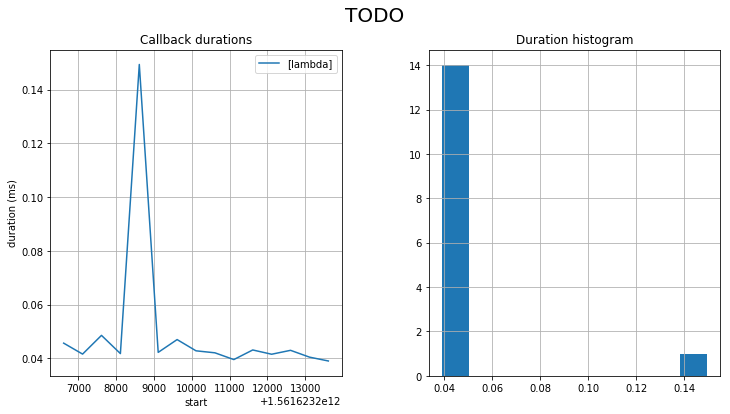

In [4]:
data_util = utils.DataModelUtil(data_model)

callback_symbols = data_util.get_callback_symbols()

# Plot durations
for obj, symbol in callback_symbols.items():
    duration_ns = data_util.get_callback_durations(obj)
    duration_ms = duration_ns.apply(lambda d: d/1000000.0)

    fig = plt.figure(figsize=(12, 6))
    fig.suptitle('TODO', fontsize=20)

    ax = fig.add_subplot(1, 2, 1)
    duration_ms.plot(x='timestamp', y='duration', ax=ax)
    ax.legend([str(symbol)])
    ax.set_xlabel('start')
    ax.set_ylabel('duration (ms)')
    ax.title.set_text('Callback durations')
    ax.grid()

    ax = fig.add_subplot(1, 2, 2)
    duration_ms.hist(column='duration', ax=ax)
    ax.title.set_text('Duration histogram')

    plt.show()